### Simulate $\Delta F$

Realistic simulation of $\Delta F$ Distributions using PHENIX. The point of this notebook is to be medium realistic. Here the scattering physics are pretty spot on, because we're using phenix.fmodel which includes things like temperature factors, solvent masks, and atom types. In principle, we could even use this to look at expected anomalous differences. That may give us a handle to infer the phase of $\Delta F$ down the line. What is not realistic here is the stereochemistry of the geometry perturbation. 

In [39]:
%pylab inline
from biopandas.pdb import PandasPdb
from subprocess import call
from os import mkdir
from os.path import exists,abspath
from matplotlib import animation
from IPython.display import HTML
from crystal import crystal


inFN = '1ubq.pdb'
outDir = 'deltaf/'
iters = 100
resolution_cutoff=1.75


#prior = lambda shape: 0.1*np.random.standard_t(10., shape)
prior = lambda shape: np.random.laplace(0., 1.0, shape)
#prior = lambda shape: np.random.normal(0., 0.1, shape)

if not exists(outDir):
    mkdir(outDir)
    

Populating the interactive namespace from numpy and matplotlib


/home/kmdalton/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [40]:
F = None


iters=10

call(['phenix.fmodel', inFN, f'high_resolution={resolution_cutoff:0.2f}', 'format=cns'])
f = crystal().read_hkl(inFN + '.hkl').remove_centrics()
Foff = (f.FMODEL*np.exp(1j*f.PHASE)).values
D = f.D.values
Fon  = None

for i in range(iters):
    pdb = PandasPdb().read_pdb(inFN)
    pdb.df['ATOM'].loc[:,['x_coord', 'y_coord', 'z_coord']] += prior(
        np.shape(pdb.df['ATOM'][['x_coord', 'y_coord', 'z_coord']]))
    outFN = f'{i:0{int((np.log10(iters)))+1}d}.pdb'
    pdb.to_pdb(outDir + outFN)
    call(['phenix.fmodel', outFN, f'high_resolution={resolution_cutoff:0.2f}', 'format=cns'], cwd=outDir)

    f = crystal().read_hkl(outDir + outFN + '.hkl').remove_centrics()
    if Fon is not None:
        Fon = np.vstack((Fon, (f.FMODEL*np.exp(1j*f.PHASE)).values))
    else:
        Fon = (f.FMODEL*np.exp(1j*f.PHASE)).values



In [41]:
#Fraction Excited for random diffuse model
P = np.linspace(1, 0, 100)
DeltaF = Foff - Fon
Fon_obs = P[:,None,None]*Fon + (1 - P)[:,None,None]*Foff
DeltaF_rad_obs = np.abs(Fon_obs) - np.abs(Foff)
DeltaF_rad = np.abs(Fon) - np.abs(Foff)

([<matplotlib.axis.YTick at 0x7fd68cd1f160>,
 <a list of 5 Text yticklabel objects>)

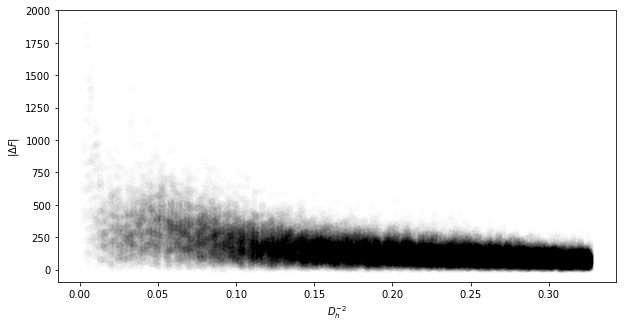

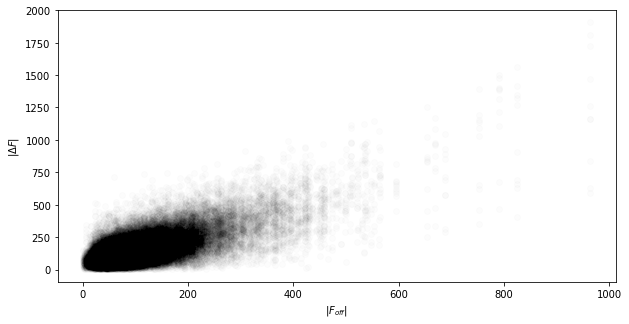

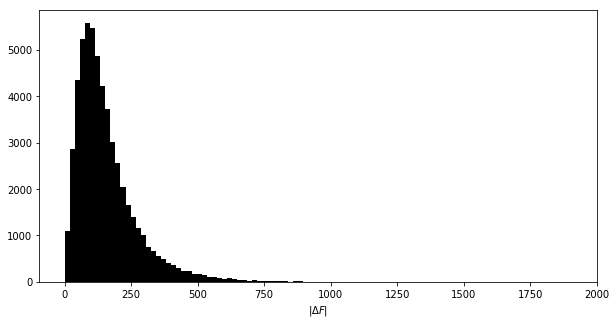

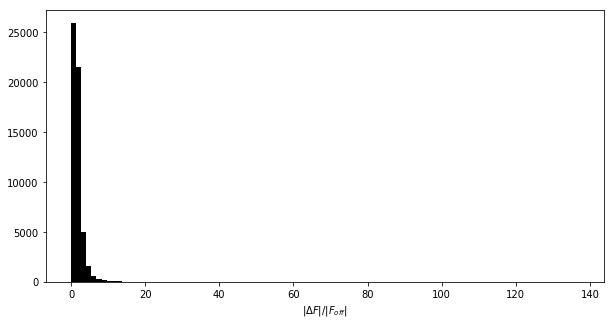

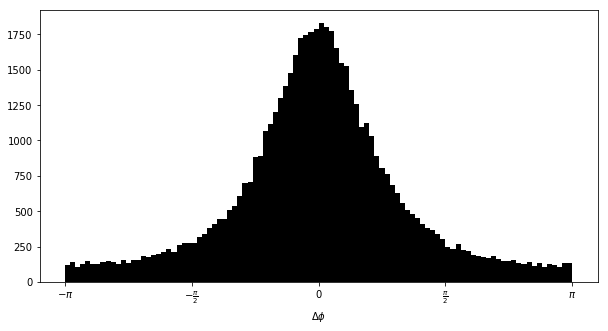

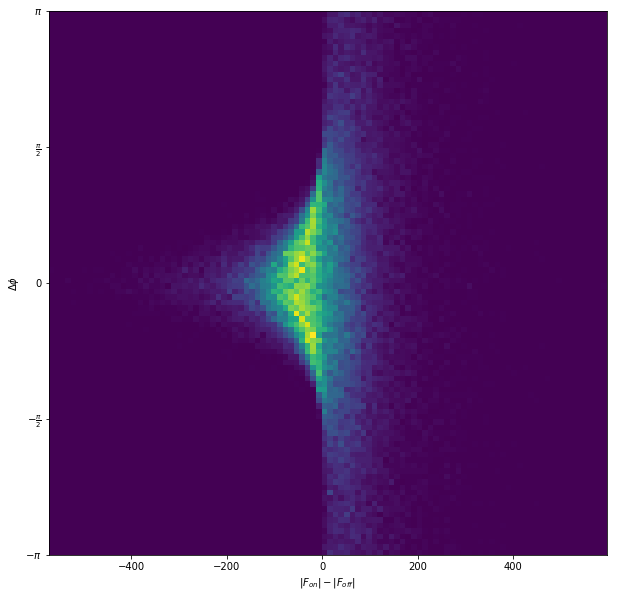

In [46]:
fs = (10, 5)

plt.figure(figsize=fs)
plt.plot((np.ones(DeltaF.shape)*D).flatten()**-2, np.abs(DeltaF).flatten(), 'ko', alpha=0.01)
plt.xlabel("$D_h^{-2}$")
plt.ylabel("$|\Delta F|$")

plt.figure(figsize=fs)
plt.plot((np.abs(Foff)*np.ones(DeltaF.shape)).flatten(), np.abs(DeltaF).flatten(), 'ko', alpha=0.01)
plt.xlabel("$|F_{off}|$")
plt.ylabel("$|\Delta F|$")

plt.figure(figsize=fs)
_ = hist(np.abs(DeltaF).flatten(), 100, color='k')
plt.xlabel("$|\Delta F|$")

plt.figure(figsize=fs)
_ = hist(np.abs(DeltaF/np.abs(Foff)).flatten(), 100, color='k')
plt.xlabel("$|\Delta F|/|F_{off}|$")

plt.figure(figsize=fs)
_ = hist(np.angle(DeltaF*np.exp(-1j*np.angle(Foff))).flatten(), 100, color='k')
plt.xlabel("$\Delta \phi$")
plt.xticks(ticks=np.pi*np.linspace(-1, 1, 5), labels=[
    r"$ - \pi$",
    r"$ - \frac {\pi} {2} $",
    r"0",
    r"$  \frac {\pi} {2} $",
    r"$  \pi$",
])



plt.figure(figsize=(10, 10))
_ = plt.hist2d(DeltaF_rad.flatten(), np.angle(DeltaF*np.exp(-1j*np.angle(Foff))).flatten(), 100)
plt.xlabel("$|F_{on}| - |F_{off}|$")
plt.ylabel("$\Delta \phi$")
plt.yticks(ticks=np.pi*np.linspace(-1, 1, 5), labels=[
    r"$ - \pi$",
    r"$ - \frac {\pi} {2} $",
    r"0",
    r"$  \frac {\pi} {2} $",
    r"$  \pi$",
])

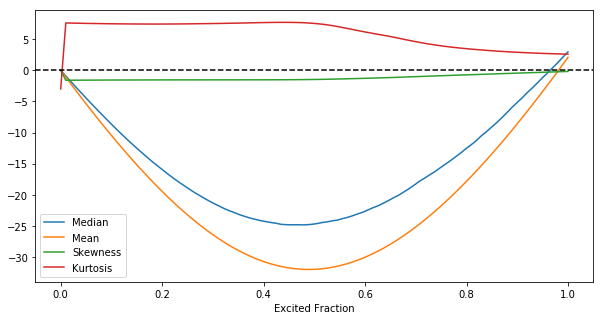

In [47]:
from scipy.stats import skew,kurtosis

i,j,k = np.shape(DeltaF_rad_obs)
np.mean(DeltaF_rad_obs.reshape((i, j*k)), 1)

plt.figure(figsize=(10, 5))
plot(P, np.median(DeltaF_rad_obs.reshape((i, j*k)), 1), label='Median')
plot(P, np.mean(DeltaF_rad_obs.reshape((i, j*k)), 1), label='Mean')
plot(P, skew(DeltaF_rad_obs.reshape((i, j*k)), 1), label='Skewness')
plot(P, kurtosis(DeltaF_rad_obs.reshape((i, j*k)), 1), label='Kurtosis')
plt.xlabel("Excited Fraction")
plt.axhline(0., color='k', linestyle='--')
plt.legend()

In [48]:
f = plt.figure(figsize=(10,5))
n,bins,patches = hist(DeltaF_rad_obs.flatten(), 70, color='k', normed=True)
t = plt.title(f"Fraction Excited = {P[0]:0.2f}")
l = plt.axvline(np.median(DeltaF_rad_obs), linestyle='--', color='r')
plt.xlabel(r"$|F_{on}^{obs}| - |F_{off}|$")
ax = plt.gca()

def update(i):
    t.set_text(f"Fraction Excited = {P[i]:0.2f}")
    n,_ = np.histogram(DeltaF_rad_obs[i], bins, normed=True)
    for j,patch in enumerate(patches):
        patch.set_height(n[j])
    median = np.median(DeltaF_rad_obs[i])
    l.set_xdata([median, median])
    return patches

plt.close()
anim = animation.FuncAnimation(f, update, frames=100, interval=100)
HTML(anim.to_html5_video())
#update(0)

/home/kmdalton/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/kmdalton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, '$|F_{on}| - |F_{off}|$')

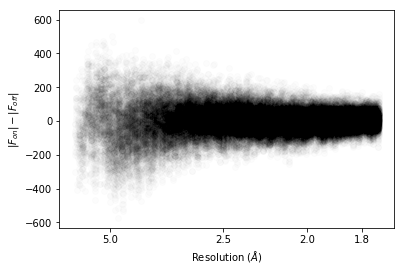

In [49]:
plt.plot(D**-2*np.ones(DeltaF_rad.shape), DeltaF_rad, 'ko', alpha=0.01)
ticks = np.array([1.8, 2., 2.5, 5])
plt.xlabel(r"Resolution ($\AA$)")
plt.xticks(ticks**-2, ticks)
plt.ylabel(r"$|F_{on}| - |F_{off}|$")

In [51]:
f = plt.figure(figsize=(10,10))

p = plt.plot(DeltaF_rad.flatten(), DeltaF_rad_obs[0].flatten(), 'ko', alpha=0.01)[0]



t = plt.title(f"Fraction Excited = {P[0]:0.2f}")
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$|F_{on}^{obs}| - |F_{off}|$")
ax = plt.gca()

def update(i):
    i = np.concatenate((np.arange(len(P)), np.arange(len(P))[::-1]))[i]
    t.set_text(f"Fraction Excited = {P[i]:0.2f}")
    p.set_xdata(DeltaF_rad.flatten())
    p.set_ydata(DeltaF_rad_obs[i].flatten())
    return [p,]

plt.close()
anim = animation.FuncAnimation(f, update, frames=199, interval=100)
HTML(anim.to_html5_video())
#update(0)

In [52]:
f = plt.figure(figsize=(10,10))

x = (DeltaF_rad/np.abs(Foff)).flatten()
y = (DeltaF_rad_obs[0]/np.abs(Foff)).flatten()
p = plt.plot(x, y, 'ko', alpha=0.01)[0]

y = (DeltaF_rad_obs/np.abs(Foff)[None,:]).flatten()
plt.xlim(np.percentile(x, (1, 99)))
plt.ylim(np.percentile(y, (1, 99)))


t = plt.title(f"Fraction Excited = {P[0]:0.2f}")
plt.xlabel(r"$\frac{|F_{on}| - |F_{off}|} {|F_{off}|}$")
plt.ylabel(r"$\frac{|F_{on}^{obs}| - |F_{off}|} {|F_{off}|}$")
ax = plt.gca()

def update(i):
    i = np.concatenate((np.arange(len(P)), np.arange(len(P))[::-1]))[i]
    t.set_text(f"Fraction Excited = {P[i]:0.2f}")
    p.set_xdata((DeltaF_rad/np.abs(Foff)).flatten())
    p.set_ydata((DeltaF_rad_obs[i]/np.abs(Foff)).flatten())
    return [p,]

plt.close()
anim = animation.FuncAnimation(f, update, frames=199, interval=100)
HTML(anim.to_html5_video())
#update(0)

In [165]:
x = np.angle(Foff[:,None]*np.ones(DeltaF.shape)).flatten()
y = np.angle(DeltaF).flatten()
mag = (np.abs(Fon) - np.abs(Foff)[:,None]).flatten()
sigma = (mag - np.mean(mag))/np.std(mag)


nx = 30
ny = 20
xbins = np.linspace(-np.pi, np.pi, nx)
ybins = np.linspace(-np.pi, np.pi, ny)


H, xbins, ybins = np.histogram2d(x, y, (xbins,ybins), normed=True)
f = plt.figure(figsize=(10,10))
im = plt.imshow(H.T, origin='lower', aspect=nx/ny)
ax = plt.gca()
xmin,xmax = plt.xlim()

ax.set_xticks([
    1.00*xmin + 0.00*xmax,
    0.75*xmin + 0.25*xmax,
    0.5*xmin + 0.5*xmax,
    0.25*xmin + 0.75*xmax,
    0.00*xmin + 1.00*xmax,
],[
    r"$-\pi$",
    r"$-\frac{\pi} {2}$",
    r"$0$",
    r"$\frac{\pi} {2}$",
    r"$\pi$",
]
)

ymin,ymax = plt.ylim()

ax.set_yticks([
    1.00*ymin + 0.00*ymax,
    0.75*ymin + 0.25*ymax,
    0.5*ymin + 0.5*ymax,
    0.25*ymin + 0.75*ymax,
    0.00*ymin + 1.00*ymax,
],[
    r"$-\pi$",
    r"$-\frac{\pi} {2}$",
    r"$0$",
    r"$\frac{\pi} {2}$",
    r"$\pi$",
]
)


ax.set_xlabel(r"$\angle F_{off} (rad)$")
ax.set_ylabel(r"$\angle \Delta F$ (rad)")
nframes=200
delta = 0.1 #Height of z slice
def update(i):
    sigma_level = np.linspace(-3, 3, nframes)[i]
    ax.set_title(f"$Z(|F_{{on}}| - |F_{{off}}|)=${sigma_level:1.2f}")
    H,_,_ = np.histogram2d(
        x[(sigma>sigma_level-delta) & (sigma<sigma_level + delta)],
        y[(sigma>sigma_level-delta) & (sigma<sigma_level + delta)],
        (xbins, ybins),
        normed=True
    )
    im.set_data(H.T)
    ax.set_yticks([
        1.00*ymin + 0.00*ymax,
        0.75*ymin + 0.25*ymax,
        0.5*ymin + 0.5*ymax,
        0.25*ymin + 0.75*ymax,
        0.00*ymin + 1.00*ymax,
    ],[
        r"$-\pi$",
        r"$-\frac{\pi} {2}$",
        r"$0$",
        r"$\frac{\pi} {2}$",
        r"$\pi$",
    ]
    )
    
    return im
plt.close()
anim = animation.FuncAnimation(f, update, frames=nframes, interval=20)
HTML(anim.to_html5_video())

ValueError: operands could not be broadcast together with shapes (6766,1) (10,6766) 